**ProBERT implementation**

---
[Gendered Ambiguous Pronouns Shared Task: Boosting Model Confidence
by Evidence Pooling ](https://aclanthology.org/W19-3820.pdf)

Sandeep Attree

# installs and imports

In [56]:
!pip install seqeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
!git clone https://github.com/SapienzaNLP/nlp2022-hw3.git

fatal: destination path 'nlp2022-hw3' already exists and is not an empty directory.


In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import json
import random
import numpy as np
import torch
import os
from typing import List, Dict
import matplotlib.pyplot as plt
from collections import Counter

from torch.utils.data import DataLoader
# from nltk.tokenize import word_tokenize



In [5]:

from tqdm import tqdm
import torch.nn.functional as F
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.random.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
from seqeval.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

cuda


In [6]:
!pip install sentencepiece


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [41]:
# from transformers import AutoTokenizer, AutoModelForSequenceClassification, AlbertForSequenceClassification, RobertaForSequenceClassification 
from transformers import AutoTokenizer,AutoModelForSequenceClassification, RobertaForSequenceClassification, AlbertForSequenceClassification


checkpoint = 'albert-base-v1'
# checkpoint = 'roberta-base'
# checkpoint = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [8]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset

In [10]:
project_folder = '/content/nlp2022-hw3'

train_path = os.path.join(project_folder, 'data', 'train.tsv')
dev_path = os.path.join(project_folder, 'data', 'dev.tsv')

In [11]:
# taken from evaluate.py
def read_dataset(path: str) -> List[Dict]:
    samples: List[Dict] = []
    pron_counter = Counter()
    with open(path) as f:
        next(f)
        for line in f:
            (
                id,
                text,
                pron,
                p_offset,
                entity_A,
                offset_A,
                is_coref_A,
                entity_B,
                offset_B,
                is_coref_B,
                _,
            ) = line.strip().split("\t")
            pron_counter[pron.lower()] += 1
            samples.append(
                {
                    "id": id,
                    "text": text,
                    "pron": pron,
                    "p_offset": int(p_offset),
                    "entity_A": entity_A,
                    "offset_A": int(offset_A),
                    "is_coref_A": is_coref_A,
                    "entity_B": entity_B,
                    "offset_B": int(offset_B),
                    "is_coref_B": is_coref_B,
                }
            )
    # print(pron_counter)
    return samples

In [12]:
samples = read_dataset(dev_path)
samples[0]

{'id': 'validation-1',
 'text': 'He admitted making four trips to China and playing golf there. He also admitted that ZTE officials, whom he says are his golf buddies, hosted and paid for the trips. Jose de Venecia III, son of House Speaker Jose de Venecia Jr, alleged that Abalos offered him US$10 million to withdraw his proposal on the NBN project.',
 'pron': 'him',
 'p_offset': 256,
 'entity_A': 'Jose de Venecia Jr',
 'offset_A': 208,
 'is_coref_A': 'FALSE',
 'entity_B': 'Abalos',
 'offset_B': 241,
 'is_coref_B': 'FALSE'}

In [13]:
# enclosing pornouns and entities with mention tags
def add_tags(sample):
  # <A> <B> <P> enclosing with tags
  out = ""
  pos_dict = {}
  
  pos_dict[sample['p_offset']] = ['<P>', len(sample['pron'])]
  # pos_dict[sample['p_offset']] = ['<P>', len(sample['pron'])]
  pos_dict[sample['offset_A']] = ['<A>', len(sample['entity_A'])]
  pos_dict[sample['offset_B']] = ['<B>', len(sample['entity_B'])]
  positions = list(pos_dict.keys())
  positions.sort()

  start = 0
  end = 0
  pronoun_id = None

  for i, offset in enumerate(positions):
    end = offset
    [tag, word_len] = pos_dict[offset]
    out += sample['text'][start:end] + tag
    if tag == '<P>':
      pronoun_id = len(list(out.split(" ")))
    out += " " + sample['text'][end:end+word_len] + " " +tag
    start = offset + word_len
    if i == 2:
      out +=  sample['text'][start:]
  return pronoun_id, out

# giving numerical tags to the labels
def get_label(example):
  if example['is_coref_A'] == 'TRUE':
    return 0 # entity A
  elif example['is_coref_B'] == 'TRUE':
    return 1 #entity B
  else:
    return 2 #Neither



In [14]:
# tokenising and by mapping to original positions to get word position of the pronoun to be used for pronoun pooling
def tokenize_and_align_pronoun_pos(sentence, pronoun_id):
    tokenized_inputs = tokenizer(sentence)
    word_ids = tokenized_inputs.word_ids()  # Map tokens to their respective word.

    new_pronoun_id = 0
    for word_idx in word_ids:  
        if word_idx is None:
            new_pronoun_id += 1
        else:
            if word_idx == pronoun_id:
                break
            else:
                new_pronoun_id += 1

    tokenized_inputs['pronoun_ind'] = new_pronoun_id
    # print(pronoun_id)
    # for i, wor in enumerate(word_tokenize(sentence)):
    # for i, wor in enumerate(sentence.split()):
      # print("{} - {}".format(i, wor))
    
    # print(new_pronoun_id)
    # for i, wor in enumerate(tokenized_inputs['input_ids']):
      # print("{} - {} - {}".format(i, tokenizer.decode(wor), word_ids[i]))

    return tokenized_inputs

In [15]:
# helper function to display dataset statistics
def get_stats(text):
  n_sents = len(text.split('.'))
  n_words = len(text.split(' '))
  return n_sents, n_words


In [17]:
# Dataset class
# self.stat collecs and stores statistical information to be used for report
class Dataset(torch.utils.data.Dataset):
  
    def __init__(self, dataset_path: str):
        self.x = []
        self.stat = {'Nsentences':[], 'Nwords': [], 'Na':0, 'Nb':0, 'Nn':0, 'pronoun':{} }
        self.build(dataset_path)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx]

    def __get_stat___(self):
        print("{} samples ". format(len(self.x)))
        print("avg length of text is {} sentences  ". format(sum(self.stat['Nsentences']) / len(self.stat['Nsentences'])))
        print("avg length of sentence is {} words  ". format(sum(self.stat['Nwords']) / len(self.stat['Nwords'])))
        print("{} true A\t{} true B\t{} true Neither\t".format(self.stat['Na'],self.stat['Nb'], self.stat['Nn'] ))

        ord_list = ['He', 'he', 'She', 'she', 'His','his','Her','her', 'him']
        sorted_dict = dict()
        for key in ord_list:
            sorted_dict[key] = self.stat['pronoun'][key]

        names = list(sorted_dict.keys())
        values = list(sorted_dict.values())
        plt.pie(values, labels=names)
        plt.axis('equal')
        plt.show()

    def build(self, dataset_path: str) -> None:
        samples = read_dataset(dataset_path)
        # preprocess_function
        for i, sample in enumerate(samples):
          if sample['pron'] in self.stat['pronoun']:
            self.stat['pronoun'][sample['pron']] +=1
          else:

            self.stat['pronoun'][sample['pron']] =1
          pronoun_id, sentence = add_tags(sample)
          n_sents, n_words = get_stats(sentence)
          self.stat['Nsentences'].append(n_sents)
          self.stat['Nwords'].append(n_words)

          input = tokenize_and_align_pronoun_pos(sentence, pronoun_id)
          label = get_label(sample)
          if label == 0:
            self.stat['Na']+=1
          elif label == 1:
            self.stat['Nb']+=1
          else:
            self.stat['Nn']+=1

          input['label'] = label
          self.x.append(input)


In [18]:
train_dataset = Dataset(train_path)
dev_dataset = Dataset(dev_path)

2998 samples 
avg length of text is 4.361240827218145 sentences  
avg length of sentence is 77.75850567044697 words  
1330 true A	1353 true B	315 true Neither	


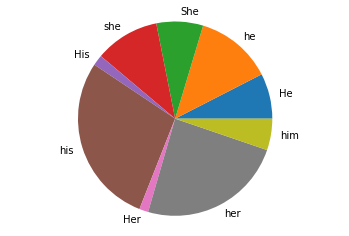

In [19]:
train_dataset.__get_stat___()

454 samples 
avg length of text is 4.405286343612334 sentences  
avg length of sentence is 76.95374449339207 words  
187 true A	205 true B	62 true Neither	


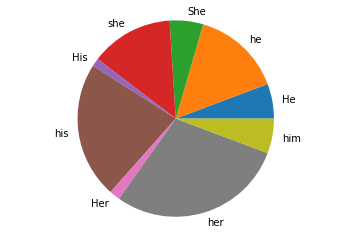

In [20]:
dev_dataset.__get_stat___()

## Data exploration

# ProBERT Model

In [42]:
# the model architecture is an imprelemtation of ProBERT paper
# slightly modified from my submission for hw 2

class ProBERT(torch.nn.Module):
    def __init__(self, 
                 hparams,
                 *args, **kwargs) -> None:
        super().__init__()

        self.num_labels = hparams.num_labels
        # layers AutoModel
        
        self.bert_model = AutoModelForSequenceClassification.from_pretrained(hparams.language_model_name, output_hidden_states = True )
        # self.bert_model = RobertaForSequenceClassification.from_pretrained(hparams.language_model_name, output_hidden_states = True )
        # self.bert_model = AlbertForSequenceClassification.from_pretrained(hparams.language_model_name, output_hidden_states = True )
        self.dropout = torch.nn.Dropout(0.1)

        self.classifier = torch.nn.Linear(
            self.bert_model.config.hidden_size, hparams.num_labels, bias=False
        )
        self.softmax = torch.nn.Softmax(dim = -1)

    def forward(
        self,
        input_ids: torch.Tensor = None,
        attention_mask: torch.Tensor = None,
        token_type_ids: torch.Tensor = None,
        pronoun_ind: torch.Tensor = None,
        labels: torch.Tensor = None,
        compute_predictions: bool = False,
        compute_loss: bool = True,
        *args,
        **kwargs,
    ) -> torch.Tensor:
        # group model inputs and pass to the model
        model_kwargs = {
          "input_ids": input_ids, 
          "attention_mask": attention_mask
        }


        if token_type_ids != None :
            model_kwargs["token_type_ids"] = token_type_ids


        transformers_outputs = self.bert_model(input_ids = input_ids, 
                                               token_type_ids = token_type_ids, 
                                               attention_mask = attention_mask,)

        transformers_outputs = self.dropout(transformers_outputs.hidden_states[-1])
        pronoun_representations = torch.tensor([])
        for pronoun in pronoun_ind:
          p_repr = transformers_outputs[:,pronoun,:]
          if pronoun_representations.shape[0] ==  0:
              pronoun_representations = p_repr
          else:
              torch.stack((pronoun_representations, p_repr))

        classifier_output = self.classifier(pronoun_representations)
        logits = self.softmax(classifier_output)
        output = {"logits": logits}

        if compute_predictions:
            predictions = logits.argmax(dim=-1)
            output["predictions"] = predictions

        if compute_loss and labels is not None:
            output["loss"] = self.compute_loss(logits, labels)
        return output

    def compute_loss(
        self, logits: torch.Tensor, labels: torch.Tensor
    ) -> torch.Tensor:
        """
        Compute the loss of the model.
        Args:
            logits (`torch.Tensor`):
                The logits of the model.
            labels (`torch.Tensor`):
                The labels of the model.
        Returns:
            obj:`torch.Tensor`: The loss of the model.
        """
        return F.cross_entropy(
            logits.view(-1, self.num_labels),
            labels.view(-1),
            ignore_index=-100,
            )



In [43]:
project_folder = '/content/nlp2022-hw3'
state_dict_path ='/content/drive/MyDrive/Colab Notebooks/NLP_HW3/model/'

# Train

In [23]:
# training function with early stop with patience
def train(device, model: torch.nn.Module, epochs: int, optimizer: torch.optim.Optimizer):
    epoch_loss = list()
    val_epoch_loss = list()

    early_stopping = True
    early_stopping_mode = 'loss'
    early_stopping_patience = 2
    patience_counter = 0

    number_of_training_steps = len([b for b in train_dataloader])

    for epoch in range(epochs):  # loop over the dataset multiple times
      batch_pbar = tqdm(enumerate(train_dataloader), total=number_of_training_steps)
      losses = []
      for i, batch in batch_pbar:
        # zero the parameter gradients
        optimizer.zero_grad()
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        
        loss = outputs["loss"]
        loss.backward()
        optimizer.step()
        batch_pbar.set_postfix({'loss': loss.item()})
        losses.append(loss.item())
      epoch_loss.append(torch.mean(torch.tensor(losses)))
      print('loss {:.3f} \n'.format( epoch_loss[-1]))

      torch.save(model.state_dict(),
            os.path.join(state_dict_path, 'state_{}.pt'.format(epoch)))

      number_of_validation_steps = len([b for b in dev_dataloader])
      eval_pbar = tqdm(enumerate(dev_dataloader), total=number_of_validation_steps)
      val_losses = []
      for i, batch in eval_pbar:
          with torch.no_grad():
              batch = {k: v.to(device) for k, v in batch.items()}
              # ** operator converts batch items in named arguments, (e.g. 'input_ids', 'attention_mask_ids' ...), taken as input by the model forward pass
              outputs = model(**batch, compute_predictions = False)
              val_loss = outputs["loss"]
              batch_pbar.set_postfix({'loss': loss.item()})
              val_losses.append(val_loss.item())
      val_epoch_loss.append(torch.mean(torch.tensor(val_losses)))
      print('val loss {:.3f} \n'.format( val_epoch_loss[-1]))
      # to  stop training before overfitting
      if early_stopping:
          # choose metric to monitor
          stop = early_stopping_mode == 'loss' and epoch > 0 and val_epoch_loss[-1] >= val_epoch_loss[-2]
          # set patience
          if stop:
              if patience_counter >= early_stopping_patience:
                  print('Early stop.')
                  torch.save(model.state_dict(),
                      os.path.join(state_dict_path, 'state_LATEST.pt'))
                  break
              else:
                  patience_counter += 1
                  print(f'-- Patience {patience_counter} out of {early_stopping_patience}.\n')
    return epoch_loss, val_epoch_loss

# Predict PostProcess Evaluate

In [24]:
# prediction model that predict loading the model from saves state
def predict(model_to_predict, weights_path, sentences, device):

  model_to_predict.load_state_dict(torch.load(weights_path, map_location=torch.device(device)))
  sentences_pbar = tqdm(enumerate(sentences), total=len(sentences))
  out = []
  for i, sample in sentences_pbar:
    pronoun_id, sentence = add_tags(sample)
    input = tokenize_and_align_pronoun_pos(sentence, pronoun_id)
    label = get_label(sample)
    input['label'] = get_label(sample)
    batch = {k: torch.unsqueeze(torch.tensor(v), 0).to(device) for k, v in input.items()}
    Y_hat = model_to_predict.forward(**batch, compute_predictions = True)
    output = torch.squeeze(Y_hat['predictions'],0)
    out.append( output)
  predictions = postprocess(sentences, out)
  
  return predictions

# postprocess function used to transform from prediction of a class to the expected format for evaluation
# with list of [[pronoun, pornoun offset], [correct entity, entity offset]]
def postprocess(sentences, outputs):
  predictions = []
  for sent, pred in zip(sentences,outputs ):
    prediction = []
    prediction.append([sent['pron'], sent['p_offset']])
    if pred == 0: # entity A
      prediction.append([sent['entity_A'], sent['offset_A']])
    elif pred == 1: # entity B
      prediction.append([sent['entity_B'], sent['offset_B']])
    else:
      prediction.append([None, None])
    predictions.append(prediction)
  return predictions

# evaluation function taken from evaluate.py 
def evaluate(predictions_s, samples):
    total = 0
    correct = 0
    for pred, label in zip(predictions_s, samples):
        gold_pron_offset = label["p_offset"]
        pred_pron_offset = pred[0][1] if len(pred[0]) > 0 else None
        gold_pron = label["pron"]
        pred_pron = pred[0][0] if len(pred[0]) > 0 else None
        gold_both_wrong = label["is_coref_A"] == "FALSE" and label["is_coref_B"] == "FALSE"
        pred_entity_offset = pred[1][1] if len(pred[1]) > 0 else None
        pred_entity = pred[1][0] if len(pred[1]) > 0 else None
        if gold_both_wrong:
            if pred_entity is None and gold_pron_offset == pred_pron_offset and gold_pron == pred_pron:
                correct += 1
            total += 1
        else:
            gold_entity_offset = (
                label["offset_A"] if label["is_coref_A"] == "TRUE" else label["offset_B"]
            )
            gold_entity = (
                label["entity_A"] if label["is_coref_A"] == "TRUE" else label["entity_B"]
            )
            if (
                gold_pron_offset == pred_pron_offset
                and gold_pron == pred_pron
                and gold_entity_offset == pred_entity_offset
                and gold_entity == pred_entity
            ):
                correct += 1
            total += 1
    print(f"# instances: {total}")
    acc = float(correct) / total
    print(f"# accuracy: {acc:.4f}")

In [38]:
# function used to reformat predictions back to classes to build confusion matrix
def flatten_pred(samples, preds):
  pred_flat = []
  for i, sample in enumerate(samples):
    pred_entity = preds[i][1][0]
    pred_entity_offset = preds[i][1][1]

    if pred_entity == sample['entity_A']:
      if pred_entity_offset == sample['offset_A']:
        pred_flat.append(0)
    elif pred_entity == sample['entity_B']:
      if pred_entity_offset == sample['offset_B']:
        pred_flat.append(1)
    elif pred_entity == None:
      if pred_entity_offset == None:
        pred_flat.append(2)
  return pred_flat

    
tags = ['A', 'B','Neither']

# func that computes and plot confusion matrix 
def plots(Y_true, Y_pred):
  
  y_true_flat = [get_label(sample) for sample in Y_true]

  pred_flat = flatten_pred(Y_true, Y_pred)
  cm = confusion_matrix(y_true_flat, pred_flat)
  cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  fig, ax = plt.subplots(figsize=(10,10))
  sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=tags, yticklabels=tags)
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show(block=False)

# Experiment

In [25]:
batch_size = 8
num_workers = 8
epochs = 10
device = "cuda" if torch.cuda.is_available() else "cpu"

In [26]:
train_dataloader = DataLoader(
    train_dataset, shuffle=True, batch_size=batch_size, collate_fn=data_collator
)
dev_dataloader = DataLoader(
    dev_dataset, shuffle=True, batch_size=batch_size, collate_fn=data_collator
)

In [44]:

class HyperParams():
    language_model_name = checkpoint
    num_labels = 3
    fine_tune_lm = True
    batch_size = batch_size

hparams = HyperParams()

In [45]:
model = ProBERT(hparams)
model.to(device)


Some weights of the model checkpoint at albert-base-v1 were not used when initializing AlbertForSequenceClassification: ['predictions.dense.bias', 'predictions.decoder.weight', 'predictions.LayerNorm.weight', 'predictions.decoder.bias', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.dense.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

ProBERT(
  (bert_model): AlbertForSequenceClassification(
    (albert): AlbertModel(
      (embeddings): AlbertEmbeddings(
        (word_embeddings): Embedding(30000, 128, padding_idx=0)
        (position_embeddings): Embedding(512, 128)
        (token_type_embeddings): Embedding(2, 128)
        (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): AlbertTransformer(
        (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
        (albert_layer_groups): ModuleList(
          (0): AlbertLayerGroup(
            (albert_layers): ModuleList(
              (0): AlbertLayer(
                (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
                (attention): AlbertAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=True)
   

In [46]:
# from torch.optim import Adam
# optim
learning_rate = 4e-6
weight_decay = 0.01
transformer_learning_rate = 4e-6
transformer_weight_decay = 0.01
# optimizer
groups = [
  {
    "params": model.classifier.parameters(),
    "lr": learning_rate,
    "weight_decay": weight_decay,
  },
  {
    "params": model.bert_model.parameters(),
    "lr": transformer_learning_rate,
    "weight_decay": transformer_weight_decay,
  }, ]

# optimizer = Adam(groups,lr=5*1e-6, betas=(0.9, 0.999), eps=1e-04,)

In [47]:
from torch.optim import AdamW
optimizer = AdamW(groups, betas=(0.9, 0.999), eps=1e-06,)

In [48]:
# CUDA_LAUNCH_BLOCKING=1
epoch_loss, val_epoch_loss = train(device, model, epochs = 10, optimizer = optimizer)

100%|██████████| 375/375 [01:20<00:00,  4.65it/s, loss=1.07]


loss 1.026 



100%|██████████| 57/57 [00:04<00:00, 13.44it/s]


val loss 1.029 



100%|██████████| 375/375 [01:20<00:00,  4.66it/s, loss=0.984]


loss 1.014 



100%|██████████| 57/57 [00:04<00:00, 13.48it/s]


val loss 1.028 



100%|██████████| 375/375 [01:20<00:00,  4.66it/s, loss=0.992]


loss 1.011 



100%|██████████| 57/57 [00:04<00:00, 13.32it/s]


val loss 1.023 



100%|██████████| 375/375 [01:20<00:00,  4.68it/s, loss=1.25]


loss 1.005 



100%|██████████| 57/57 [00:04<00:00, 13.18it/s]


val loss 1.038 

-- Patience 1 out of 2.



100%|██████████| 375/375 [01:20<00:00,  4.66it/s, loss=0.985]


loss 0.998 



100%|██████████| 57/57 [00:04<00:00, 13.46it/s]


val loss 1.026 



100%|██████████| 375/375 [01:20<00:00,  4.65it/s, loss=0.9]


loss 0.985 



100%|██████████| 57/57 [00:04<00:00, 13.32it/s]


val loss 1.004 



100%|██████████| 375/375 [01:20<00:00,  4.67it/s, loss=1.12]


loss 0.954 



100%|██████████| 57/57 [00:04<00:00, 13.54it/s]


val loss 0.998 



100%|██████████| 375/375 [01:20<00:00,  4.66it/s, loss=0.834]


loss 0.913 



100%|██████████| 57/57 [00:04<00:00, 13.34it/s]


val loss 0.978 



100%|██████████| 375/375 [01:20<00:00,  4.65it/s, loss=0.773]


loss 0.880 



100%|██████████| 57/57 [00:04<00:00, 13.21it/s]


val loss 0.969 



100%|██████████| 375/375 [01:19<00:00,  4.70it/s, loss=0.917]


loss 0.846 



100%|██████████| 57/57 [00:04<00:00, 13.26it/s]

val loss 0.978 

-- Patience 2 out of 2.



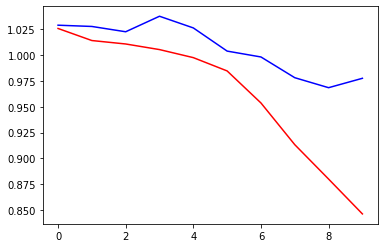

In [50]:
# TRaining loss to determine best state for evaluation
plt.plot(np.array(epoch_loss), 'r', np.array(val_epoch_loss), 'b')

In [53]:
# Prediction
sentences = read_dataset(dev_path)
state_dict_path='/content/drive/MyDrive/Colab Notebooks/NLP_HW3/model/'
# state_5_albert_v1_base_best
# state_8 for roberta best
# state_7 for bert best
state_path = os.path.join(state_dict_path, 'albert_best.pt')
predictions = predict(model, state_path, sentences, device)

100%|██████████| 454/454 [00:06<00:00, 72.87it/s]


In [54]:
evaluate(predictions, sentences)

# instances: 454
# accuracy: 0.7863


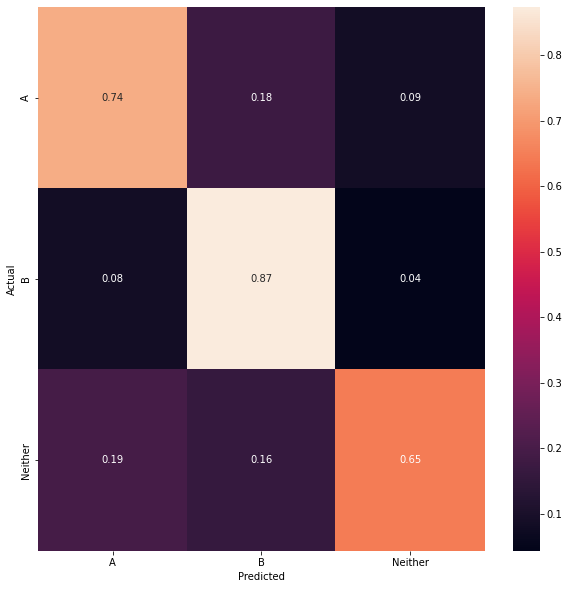

In [55]:
plots(sentences, predictions )